# Temperature estimation


/opt/jaspy/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 't2m' contains unknown cell method 'nanmean'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


2 metre temperature / (K)           (time: 13870; hour_of_day: 24)
     Dimension coordinates:
          time                           x                   -
          hour_of_day                    -                   x
     Auxiliary coordinates:
          day_of_year                    x                   -
          year                           x                   -
267.3597893143872
267.3597893143872
274.700150929442
274.700150929442


/opt/jaspy/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'hour_of_day'.
  warnings.warn(msg.format(self.name()))


unknown / (1)                       (-- : 366; hour_of_day: 24)
     Dimension coordinates:
          hour_of_day                   -                 x
     Auxiliary coordinates:
          day_of_year                   x                 -
          time                          x                 -
          year                          x                 -
     Cell methods:
          nanmean: day_of_year


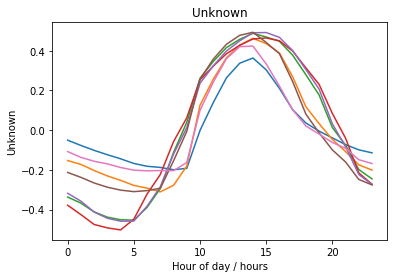

In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#!pip install pygam
#from pygam import LinearGAM
from normalised_seasonal_iris_RMSE_minmax import return_t2m_jake


In [118]:
# load in dataset
# read in UK t2m & NAO data
df = pd.read_csv("ERA5_hourly_UK.csv")
df.columns = ["date_time","t2m","ssrd","msl","nao", "w10","w100", "tcc", "tp"]
df.head()

,date_time,t2m,ssrd,msl,nao,w10,w100,tcc,tp
0,1979-01-01 00:00:00,-5.702784,-32767.0,1014.010319,-1.38,0.539450,1.686726,0.596991,-32767000.0
1,1979-01-01 01:00:00,-5.507162,-32767.0,1014.724101,-1.38,0.756348,1.752340,0.616364,-32767000.0
2,1979-01-01 02:00:00,-5.664224,-32767.0,1015.209416,-1.38,1.106655,2.131312,0.609257,-32767000.0
3,1979-01-01 03:00:00,-5.944852,-32767.0,1015.758926,-1.38,1.299900,2.487398,0.633477,-32767000.0
4,1979-01-01 04:00:00,-5.952020,-32767.0,1015.954954,-1.38,1.383135,2.694151,0.638393,-32767000.0


In [119]:
# add week
df["week"] = pd.to_numeric(pd.to_datetime(df.date_time).dt.strftime("%U"))

# Preprocessing

### Split Train/test

In [100]:
# calculate daily values
df.date_time = pd.to_datetime(df.date_time)
df_daily = df.groupby(df.date_time.dt.date).mean()
df_daily["t2mmax"] = t2mmax = df.t2m.groupby(df.date_time.dt.date).max()
df_daily["t2mmin"] = df.t2m.groupby(df.date_time.dt.date).min()

# set X equal to df_daily
X = df_daily


In [101]:
# add lag features
X["t2min_previous"] = X.t2mmin.shift(1)
X["t2m_previous"] = X.t2m.shift(1)
X["t2min_next"] = X.t2mmin.shift(-1)
X["t2m_next"] = X.t2m.shift(-1)
X = X.fillna(0)
X.drop(columns = ["w100", "tp", "nao", "w10", "msl"], inplace = True)
X.head()

,t2m,ssrd,tcc,week,t2mmax,t2mmin,t2min_previous,t2m_previous,t2min_next,t2m_next
date_time,,,,,,,,,,
1979-01-01,-4.159642,-9531.855820,0.675312,0,-2.207358,-5.952020,0.000000,0.000000,-2.470000,-1.011778
1979-01-02,-1.011778,25.708586,0.636231,0,0.282814,-2.470000,-5.952020,-4.159642,-1.418395,-0.129076
1979-01-03,-0.129076,25.569494,0.857288,0,1.041230,-1.418395,-2.470000,-1.011778,-2.098208,-0.641538
1979-01-04,-0.641538,20.183029,0.934392,0,0.469106,-2.098208,-1.418395,-0.129076,-4.261743,-2.196899
1979-01-05,-2.196899,25.340972,0.825873,0,-0.880194,-4.261743,-2.098208,-0.641538,-0.764055,2.164684


In [102]:
# create 24-hour t2m arrays as target variable
Y_list = []
for i in range(int(len(df)/24)):
    Y_list.append(df.t2m.iloc[(i*24):(i*24+24)].values)
Y = np.array(Y_list)

# add date_time index
y = pd.DataFrame(Y,index=df_daily.index)
y = y.fillna(0)


### Visualization of independent vars

In [103]:
# remove outliers
X.ssrd[X.ssrd<-5000]=0

# produce ssrd plot
#X.ssrd.hist()



/opt/jaspy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Split train/test

In [104]:
# split train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = 10,shuffle=False)

# create a dataframe of the hours for plotting purposes
X_test.index = pd.to_datetime(X_test.index)
X_test_hours = X_test.resample("1H").pad().index

# Modeling

# Linear Regression

In [105]:
from sklearn.linear_model import LinearRegression

# produce linear regression
reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [106]:
# metrics
r2_reg = r2_score(y_test,pred_reg)
mae_reg = mean_absolute_error(y_test,pred_reg)
mse_reg = mean_squared_error(y_test,pred_reg)


print("R2-score: ",r2_reg)
print("MAE-score: ",mae_reg)
print("MSE-score: ",mse_reg)



R2-score:  0.9870783812245326
MAE-score:  0.33584685903315287
MSE-score:  0.2362361525625726


# Random Forest

In [107]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [108]:
# metrics
r2_rf = r2_score(y_test,pred_rf)
mae_rf = mean_absolute_error(y_test,pred_rf)
mse_rf = mean_squared_error(y_test,pred_rf)

print("R2-score: ",r2_rf)
print("MAE-score: ",mae_rf)
print("MSE-score: ",mse_rf)

R2-score:  0.9884070329096118
MAE-score:  0.3109391046650247
MSE-score:  0.2136204802400539


Maximum number of trees can be set to 100 as there is little computational cost.

Found that winter weeks have higher MSE in comparison to summer months.

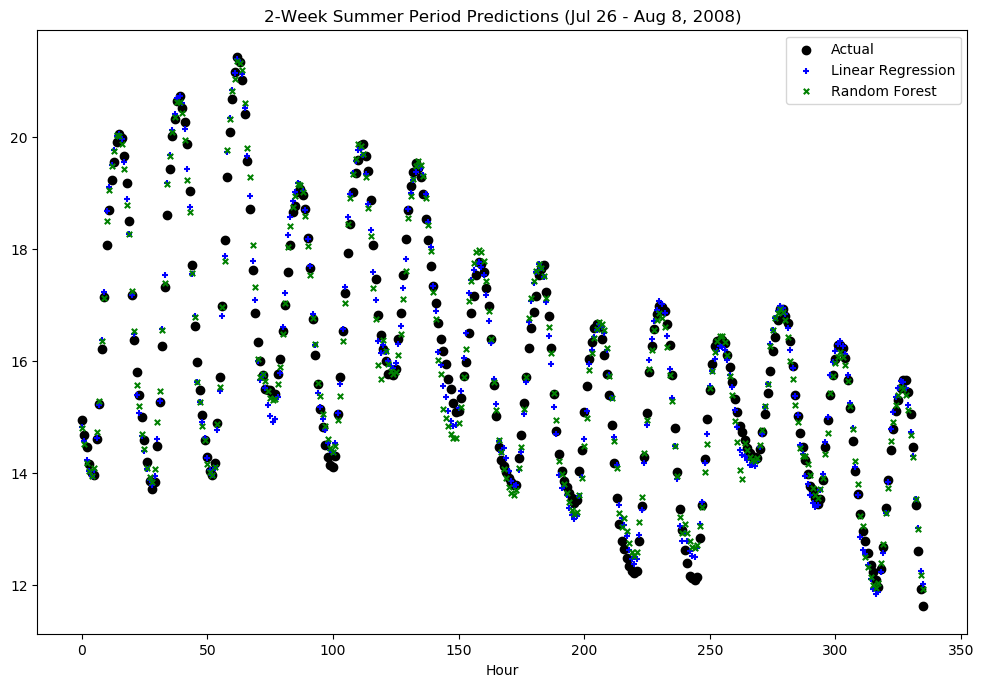

In [109]:
# generate summer/winter comparisons
y_d14_summer = y_test.iloc[60:74]
y_d14_winter = y_test.iloc[230:244]
pred_d14_summer = pred_rf[60:74]
pred_d14_winter = pred_rf[230:244]
pred_d14_summer_reg = pred_reg[60:74]
pred_d14_winter_reg = pred_reg[230:244]

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

plt.scatter(np.arange(0,14*24,1),y_d14_summer, color ="k")
plt.scatter(np.arange(0,14*24,1),pred_d14_summer_reg, color = "b", marker = "+", s=15)
plt.scatter(np.arange(0,14*24,1),pred_d14_summer, color ="g", marker = "x", s=15)
plt.xlabel("Hour")
plt.title("2-Week Summer Period Predictions (Jul 26 - Aug 8, 2008)")
plt.legend(["Actual","Linear Regression", "Random Forest"])

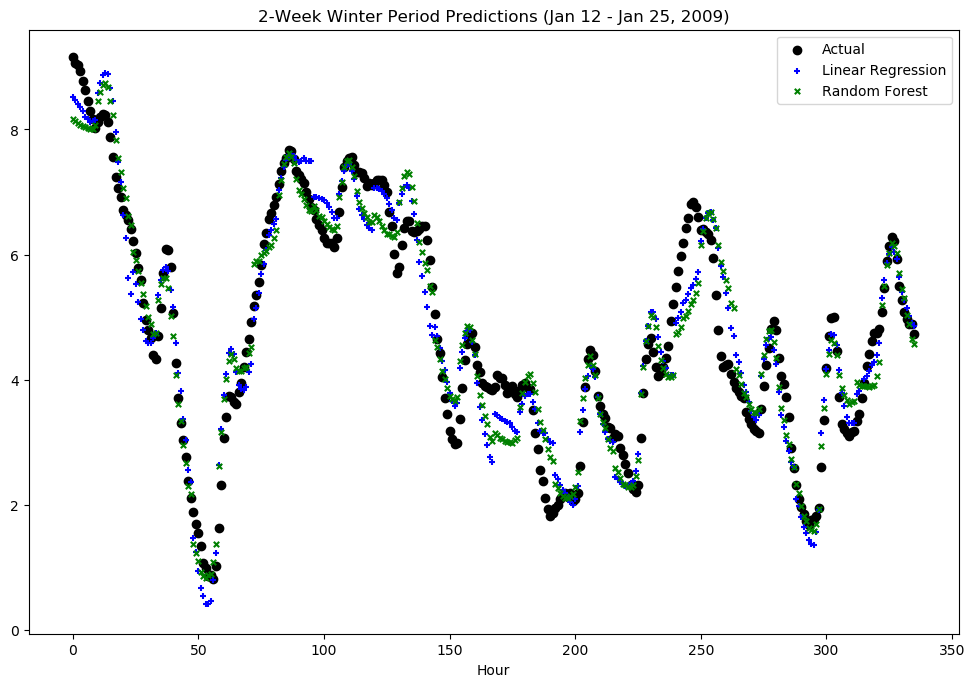

In [110]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

plt.scatter(np.arange(0,14*24,1),y_d14_winter, color ="k")
plt.scatter(np.arange(0,14*24,1),pred_d14_winter_reg, color = "b", marker = "+", s=15)
plt.scatter(np.arange(0,14*24,1),pred_d14_winter, color ="g", marker = "x", s =15)
plt.xlabel("Hour")
plt.title("2-Week Winter Period Predictions (Jan 12 - Jan 25, 2009)")
plt.legend(["Actual","Linear Regression", "Random Forest"])

In [127]:
def RMS_based_eval(timeseries1, timeseries2, timeseries3, field, case_no, method1, method2, method3):

    ''''
    timeseries_for_eval [array] must be the appropriate length for case study evaluation 
    Case1 = 168 hours
    Case2 = 216 hours
    Case3 = 672 hours
    field [str] must either be 'T2m', 'speed10m' , or 'rsds'
    case no [str] must be either 1,2 or 3.
    method_str [str] what you'd like it referred to as.
    '''
    from sklearn.metrics import mean_squared_error
    import math
    
    obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
    
    obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')
    MAE1 = np.mean(obs - timeseries1)
    RMS1 = np.sqrt(np.nanmean((obs - timeseries1)**2))
    RMS1 = math.sqrt(mean_squared_error(obs, timeseries1))
    MAE2 = np.mean(obs - timeseries2)
    RMS2 = np.sqrt(np.nanmean((obs - timeseries2)**2))
    MAE3 = np.mean(obs - timeseries3)
    RMS3 = np.sqrt(np.nanmean((obs - timeseries3)**2))
    
    fig = plt.figure(figsize=(12,4))
    plt.plot(obs_date,obs,color='k',label='ERA5 obs')
    if field == 'T2m':
        plt.plot(obs_date,timeseries1, color='b',label=method1)
        plt.plot(obs_date,timeseries2, color='g',label=method2)
        plt.plot(obs_date,timeseries3, color='r',label=method3)
        plt.ylabel('2m temperature ($^{o}$C)',fontsize=14)
        plt.title('Case study ' + case_no )
        #plt.xlabel('MAE = ' + str(MAE) + ' , RMS = ' + str(RMS))
    if field == 'speed10m':
        plt.plot(obs_date,timeseries1,color='b',label=method1)
        plt.plot(obs_date,timeseries2,color='g',label=method2)
        plt.plot(obs_date,timeseries3,color='r',label=method3)
        plt.ylabel('10m wind speed (ms$^{-1}$)',fontsize=14)
        plt.title('Case study ' + case_no)
    if field == 'rsds':
        plt.plot(obs_date,timeseries1,color='b',label=method1)
        plt.plot(obs_date,timeseries2,color='g',label=method2)
        plt.plot(obs_date,timeseries3,color='g',label=method3)
        plt.ylabel('Surface shortwave radiation (Wm$^{-2}$)',fontsize=14)
        plt.title('Case study ' + case_no )
    plt.legend(frameon=False)
    plt.savefig("plots/%s_%s.png"%(field, case_no))
    plt.show()
    return([MAE1, RMS1, MAE2, RMS2, MAE3, RMS3])

In [128]:
# index y_test to determine dates for case studies
from datetime import datetime

days = pd.to_datetime(y_test.index)
index_case1 = np.where((days>=datetime(2019,11,18)) & (days<=datetime(2019,11,24)))
input_case1_reg = pred_reg[index_case1].flatten()
input_case1 = pred_rf[index_case1].flatten()


index_case2 = np.where((days>=datetime(2020,7,1)) & (days<=datetime(2020,7,9)))
input_case2_reg = pred_reg[index_case2].flatten()
input_case2 = pred_rf[index_case2].flatten()


index_case3 = np.where((days>=datetime(2018,2,20)) & (days<=datetime(2018,3,19)))
input_case3_reg = pred_reg[index_case3].flatten()
input_case3 = pred_rf[index_case3].flatten()


In [129]:
jake_case1, jake_case2, jake_case3 = return_t2m_jake()


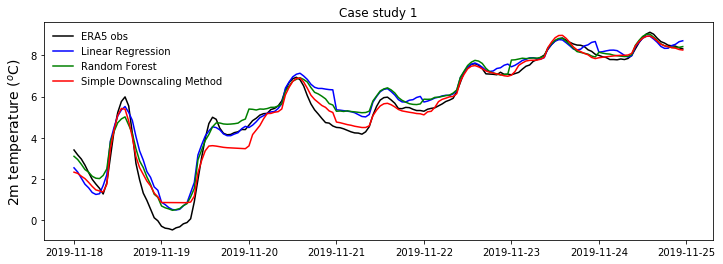

[-0.3083289629555302,
 0.6212077586439019,
 -0.3092846709051417,
 0.5417428112418328,
 -7.48078847545046e-16,
 0.49455778112366644]

In [137]:
RMS_based_eval(input_case1_reg, input_case1, jake_case1, "T2m","1","Linear Regression", "Random Forest", "Simple Downscaling Method")


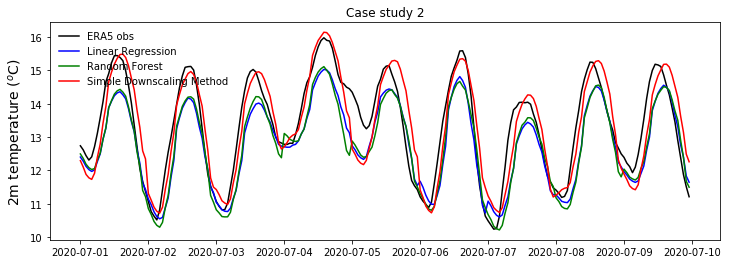

[0.5535115651951871,
 0.7892508631773486,
 0.5711866987713129,
 0.7969783353997997,
 -7.401486830834377e-17,
 0.6481124736698947]

In [138]:
RMS_based_eval(input_case2_reg, input_case2, jake_case2, "T2m","2","Linear Regression", "Random Forest", "Simple Downscaling Method")


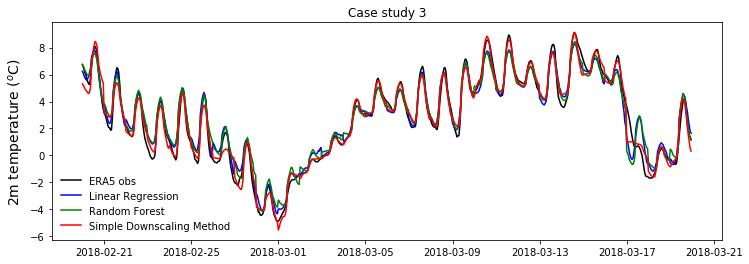

[-0.13792428845318966,
 0.635667483501125,
 -0.15405692576136645,
 0.7110257551196406,
 -1.3481279584734043e-16,
 0.5072340708701142]

In [139]:
RMS_based_eval(input_case3_reg, input_case3, jake_case3, "T2m","3","Linear Regression", "Random Forest", "Simple Downscaling Method")


t2m               0.957767
ssrd              0.001939
tcc               0.001367
week              0.001320
t2mmax            0.016557
t2mmin            0.009672
t2min_previous    0.002930
t2m_previous      0.001152
t2min_next        0.003171
t2m_next          0.004125
dtype: float64

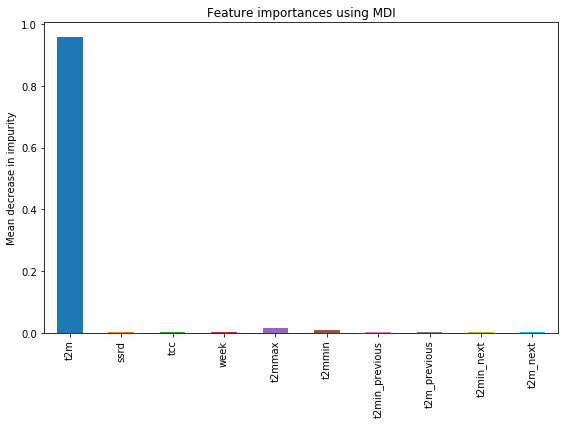

In [116]:
feature_names = X.columns
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

forest_importances